# Debugging Factor Analysis Implementation

This notebook investigates the Factor Analysis implementation step by step, focusing on:
1. Data generation
2. E-step computation
3. M-step updates
4. Full model fitting

In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns
import equinox as eqx
from jax import config
from sppcax.models import PPCA, FactorAnalysis
from sppcax.distributions import MultivariateNormal, MultivariateNormalGamma

# For better visualization
%matplotlib inline
sns.set_theme('notebook', style='dark', palette="deep")
config.update("jax_enable_x64", True)

## 1. Data Generation

First, let's generate synthetic data with known structure:

Data shapes:
X: (100, 10)
Z_true: (100, 4)
W_true: (4, 10)


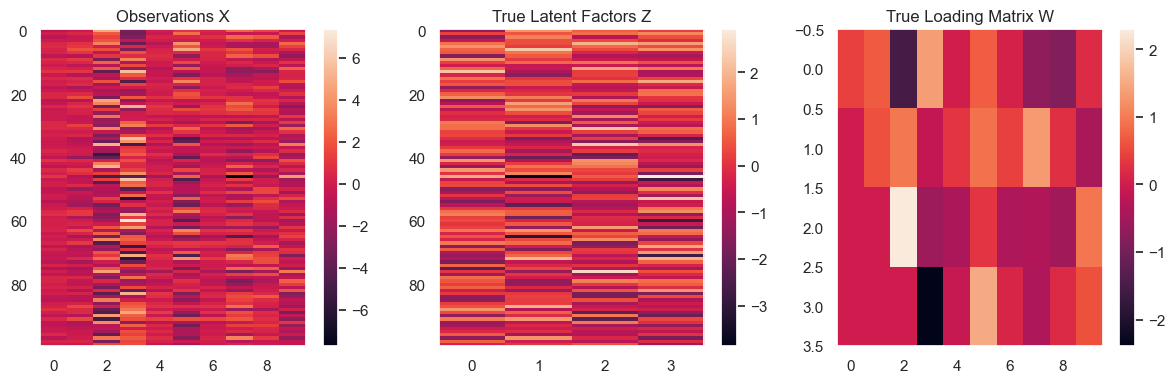

In [2]:
# Set random seed for reproducibility
key = jr.PRNGKey(0)

# Data dimensions
n_samples = 100
n_features = 10
n_components = 4

mask = jnp.transpose(jnp.clip(jnp.arange(n_features), a_max=n_components)[..., None] >= jnp.arange(n_components))

# Generate true latent factors
key, subkey = jr.split(key)
Z_true = jr.normal(subkey, (n_samples, n_components))

# Generate true loading matrix with some features being noise
key, subkey = jr.split(key)
W_true = jr.normal(subkey, (n_components, n_features)) * mask

# Generate observations with noise
key, subkey = jr.split(key)
noise = 0.1 * jr.normal(subkey, (n_samples, n_features))
X = Z_true @ W_true + noise

print("Data shapes:")
print(f"X: {X.shape}")
print(f"Z_true: {Z_true.shape}")
print(f"W_true: {W_true.shape}")

# Visualize the data
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Observations X')
plt.colorbar()

plt.subplot(132)
plt.imshow(Z_true, aspect='auto')
plt.title('True Latent Factors Z')
plt.colorbar()

plt.subplot(133)
plt.imshow(W_true, aspect='auto')
plt.title('True Loading Matrix W')
plt.colorbar()

plt.tight_layout()

The Procrustes error for the loading matrix is 1.159845942123028


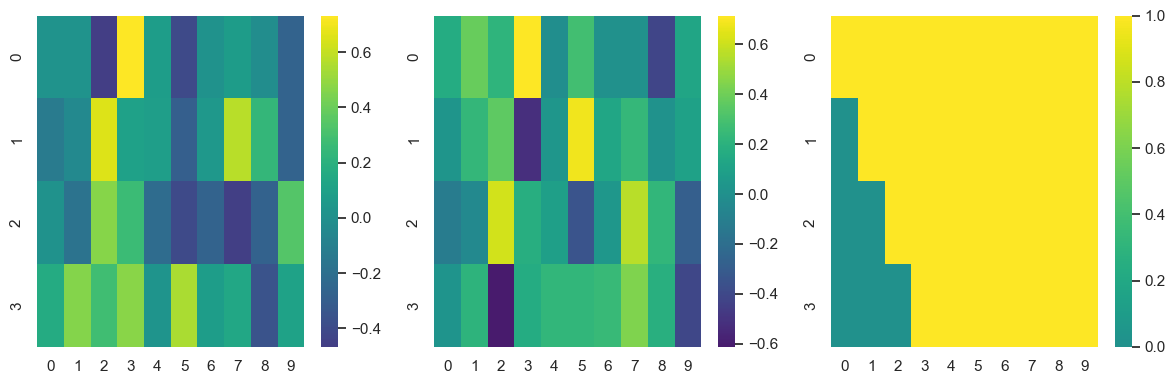

In [3]:
from sklearn.decomposition import FactorAnalysis as sklearn_fa
import numpy as np
import procrustes

z_dim = 4
u, s, v = jnp.linalg.svd(X - X.mean(0), full_matrices=False)
pca_w = v[:z_dim]

proc_trans = procrustes.orthogonal(np.asarray(pca_w.T), np.asarray(mask.T).astype(jnp.float32), scale=True)
print(f"The Procrustes error for the loading matrix is {proc_trans.error}")

# Heatmap of transformed loading matrix
pca_w_trans = proc_trans.t.T @ pca_w
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.heatmap(pca_w, cmap='viridis', fmt = ".2f", center = 0, ax=axes[0])
sns.heatmap(pca_w_trans, cmap='viridis', fmt = ".2f", center = 0, ax=axes[1])
sns.heatmap(mask, cmap='viridis', fmt = ".2f", center = 0, ax=axes[2])
fig.tight_layout()

The Procrustes error for the loading matrix is 1.3312372765558615


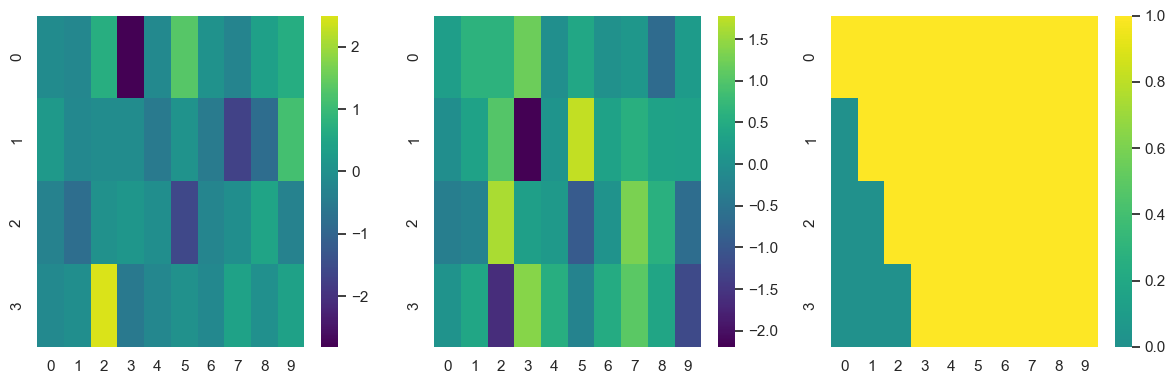

In [4]:
fa = sklearn_fa(n_components=z_dim, rotation='varimax')
res = fa.fit(X)

proc_trans = procrustes.orthogonal(np.asarray(res.components_.T), np.asarray(mask.T).astype(jnp.float32), scale=True)
print(f"The Procrustes error for the loading matrix is {proc_trans.error}")

# Heatmap of transformed loading matrix
fa_w_trans = proc_trans.t.T @ res.components_
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.heatmap(res.components_, cmap='viridis', fmt = ".2f", center = 0, ax=axes[0])
sns.heatmap(fa_w_trans, cmap='viridis', fmt = ".2f", center = 0, ax=axes[1])
sns.heatmap(mask, cmap='viridis', fmt = ".2f", center = 0, ax=axes[2])
fig.tight_layout()

## 2. E-step Investigation

Let's initialize a model and examine each part of the E-step computation:

E-step computation:
Ez + Ezz shape: (100, 20)


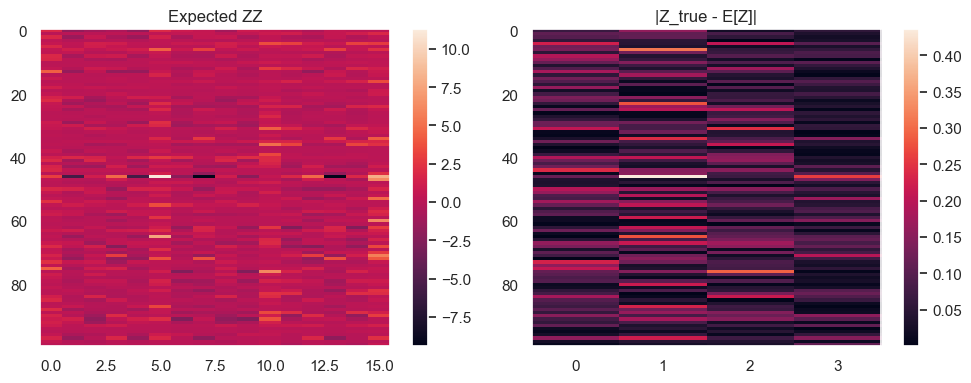

In [5]:
# Initialize model with known parameters
model = PPCA(n_components=n_components, n_features=n_features)

W_dist = MultivariateNormalGamma(
    loc=W_true.mT,  # Use true W for initialization
    scale_tril=jnp.eye(n_components)/100,
    mask=model.W_dist.mvn.mask,
    alpha=2.0,
    beta=1.0
)

model = eqx.tree_at(lambda x: x.W_dist, model, W_dist)
mean = X.mean(0)
model = eqx.tree_at(lambda x: x.mean_, model, mean)

# Step through E-step computation
print("E-step computation:")

# Compute expectations
qz = model._e_step(X)
exp_stats = qz.expected_sufficient_statistics
print(f"Ez + Ezz shape: {exp_stats.shape}")

# Visualize E-step results
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(exp_stats[:, n_components:], aspect='auto')
plt.title('Expected ZZ')
plt.colorbar()

plt.subplot(122)
plt.imshow(jnp.abs(Z_true - Z_true.mean(0) - qz.mean), aspect='auto')
plt.title('|Z_true - E[Z]|')
plt.colorbar()

plt.tight_layout()
plt.show()

## 3. M-step Investigation

Now let's examine the M-step updates:

M-step computation:


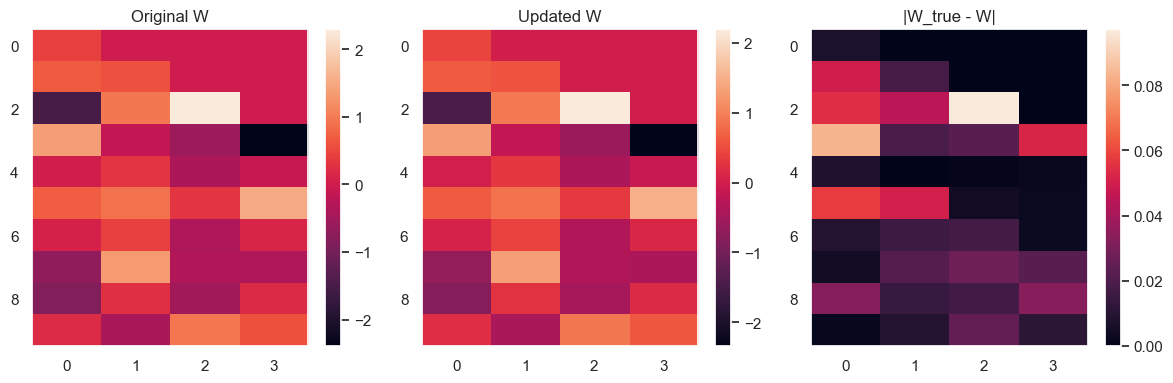

In [6]:
# Step through M-step computation
print("M-step computation:")

# 4. Update model
updated_model = model._m_step(X, qz)

# Visualize M-step results
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(model.W_dist.mean, aspect='auto')
plt.title('Original W')
plt.colorbar()

plt.subplot(132)
plt.imshow(updated_model.W_dist.mean, aspect='auto')
plt.title('Updated W')
plt.colorbar()

plt.subplot(133)
plt.imshow(jnp.abs(W_true.mT - updated_model.W_dist.mean), aspect='auto')
plt.title('|W_true - W|')
plt.colorbar()

plt.tight_layout()
plt.show()

## 4. Full Model Fitting

Let's test the complete fitting procedure:

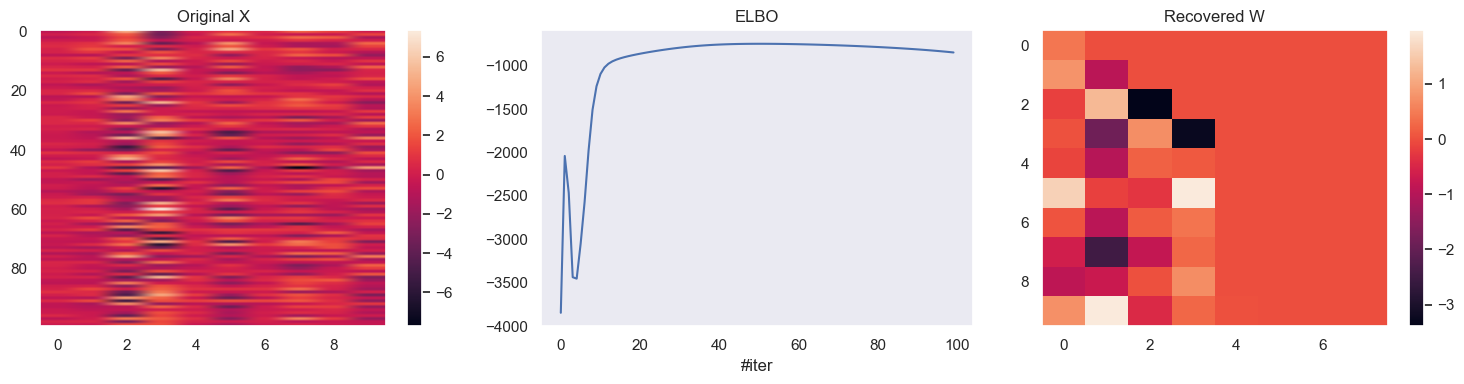

Reconstruction error: 0.011261
ARD posterior [0.27963318 0.07520214 0.09750072 0.07625257 4.8548598  4.39335728
 3.92351644 3.44940874]


In [7]:
# Initialize model
model = PPCA(n_components=2*n_components, n_features=n_features)

# Fit model
fitted_model, elbos = model.fit(X, tol=1e-2)

# Transform data
qz = fitted_model.transform(X)
X_reconstructed = fitted_model.inverse_transform(qz.mean)

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos)
plt.title('ELBO')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)

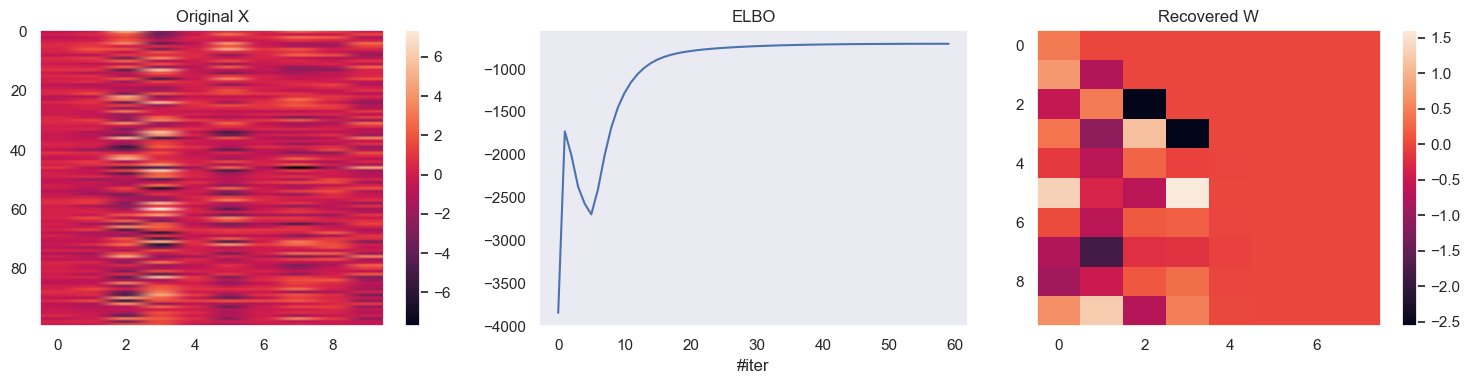

Reconstruction error: 0.014474
ARD posterior [0.29530584 0.12783076 0.42682015 0.35748669 4.79692723 4.39335725
 3.92352389 3.44940874]


In [8]:
# Initialize model
model = FactorAnalysis(n_components=2 * n_components, n_features=n_features)

# Fit model
fitted_model, elbos = model.fit(X, tol=1e-2)

# Transform data
qz = fitted_model.transform(X)
X_reconstructed = fitted_model.inverse_transform(qz.mean)

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos)
plt.title('ELBO')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)

# 

## 5. Working with missing data

We illustrate here how to mask missing data.

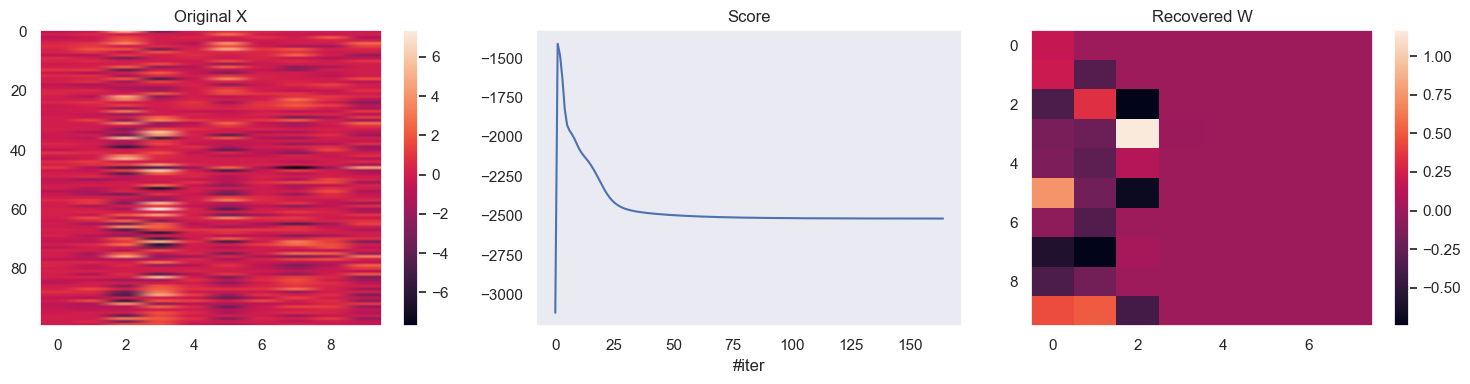

Reconstruction error: 1.303056
ARD posterior [4.64598165 3.73329226 4.58405434 5.32110869 4.85940328 4.39364081
 3.9237261  3.44952751]


In [9]:
# mask 20% of the observed features
key, _key = jr.split(key)
data_mask = jr.bernoulli(_key, p=.8, shape=X.shape)

# Initialize model
model = FactorAnalysis(n_components=2 * n_components, n_features=n_features, data_mask=data_mask)

# Fit model
fitted_model, lls = model.fit(X, tol=1e-2, n_iter=200)

# Transform data
qz = fitted_model.transform(X, use_data_mask=False)
X_reconstructed = fitted_model.inverse_transform(qz.mean)

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X * data_mask, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(lls)
plt.title('Score')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean(jnp.square((X - X_reconstructed)))
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)

## 6. Passing uncertain measurements

Finally, we illustrate here how to pass data with uncertainty associated with measurements.

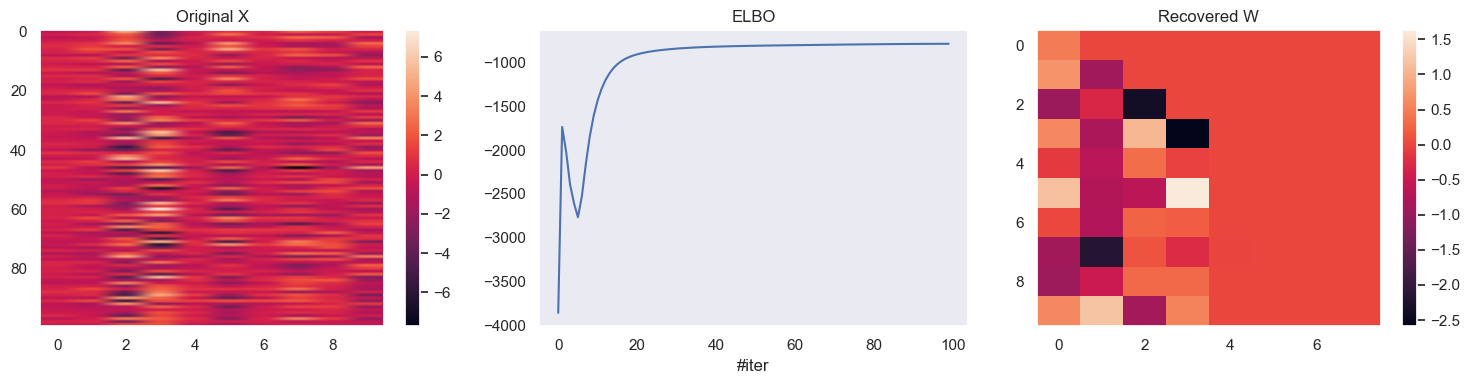

Reconstruction error: 0.014365
ARD posterior [0.3310211  0.13053737 0.42976509 0.38567069 4.8586393  4.39335738
 3.92353    3.44940875]


In [10]:
# add uncertainty to observations
X_dist = MultivariateNormal(loc=X, precision=100*jnp.eye(n_features))

# Initialize model
model = FactorAnalysis(n_components=2 * n_components, n_features=n_features)

# Fit model
fitted_model, elbos = model.fit(X_dist, tol=1e-2)

# Transform data
qz = fitted_model.transform(X_dist)
X_reconstructed = fitted_model.inverse_transform(qz.mean)

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos)
plt.title('ELBO')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)